#### Imports

In [18]:
import pandas as pd
import shutil
from copy import deepcopy
import tqdm
import cv2
import matplotlib.pyplot as plt
from skimage import measure
import numpy as np
from skimage.filters import threshold_otsu
import os

## Moving Clusters Into Folders

In [21]:
df = pd.read_csv('/home/arias1/Downloads/Drawer_58_clusters.csv')

In [22]:
original_path = '/home/arias1/Documents/GitHub/egg_cards/Images/Drawer_58/Usable'
new_path_c1 = '/home/arias1/Documents/GitHub/egg_cards/Images/Drawer_58/cluster1'
new_path_c2 = '/home/arias1/Documents/GitHub/egg_cards/Images/Drawer_58/cluster2'

In [25]:
n = len(df)
errors = []
for i in tqdm.tqdm(range(n)):
    image_name = df.iloc[i]['image']
    if df.iloc[i]['clusterid'] == 0:
        new_path = new_path_c1+'/'+image_name
    else:
        new_path = new_path_c2+'/'+image_name
    try:
        shutil.copy(original_path+'/'+image_name, new_path)
    except:
        errors.append(i)

100%|██████████████████████████████████████| 1149/1149 [00:02<00:00, 468.01it/s]


In [27]:
len(errors)

0

## Cropping Large Images

In [2]:
img = cv2.imread('/home/arias1/Documents/GitHub/egg_cards/Images/Drawer_1/cluster1/001-0010.jpg')

In [35]:
image_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
contours_grey = measure.find_contours(image_grey/255, 0.8)

In [36]:
contours_length = [len(c[:,0]) for c in contours_grey]

In [63]:
np.argsort(contours_length)[-2:]

array([169, 783])

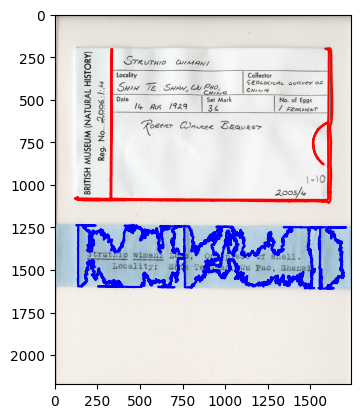

In [51]:
fig,ax = plt.subplots()
ax.imshow(img)
c1 = contours_grey[169]
c2 = contours_grey[783]
ax.plot(c1[:,1],c1[:,0],'-r')
ax.plot(c2[:,1],c2[:,0],'-b')

In [51]:
def crop_image(image,box_x,box_y,leeway_x = 0,leeway_y = 10,left_leeway=True,backup_leeway=10):
    # left_leeway refers to extending the crop on the left-side as there 
    # is box that is commonly misse on that side.
    mY,mX = np.shape(image)[:2] 
    minx = max([int(min(box_x))-leeway_x,0])
    if left_leeway is False:
        maxx = min([int(max(box_x))+leeway_x,mX])
    else:
        maxx = min([int(max(box_x))+backup_leeway,mX])
    miny = max([int(min(box_y))-leeway_y,0])
    maxy = min([int(max(box_y))+leeway_y,mY])

    img_cropped = image[miny:maxy,minx:maxx]
    new_box = np.array([[minx,miny],[maxx,miny],[maxx,maxy],[minx,maxy]])

    return img_cropped, new_box

In [76]:
def find_main_box(img,top=2,leeway_y=10,leeway_x=10,crop_leeway_x=10,crop_leeway_y=10,backup_leeway=10):
    image_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    contours_grey = measure.find_contours(image_grey/255, 0.8)
    contours_length = [len(c[:,0]) for c in contours_grey]
    contour_index = np.argsort(contours_length)[-top:]
    a,b = np.shape(img)[:2]
    contour = None
    for u,ind in enumerate(contour_index):
        c = contours_grey[ind]
        if (max(c[:,0])<a-leeway_y) and ((max(c[:,1])<b-leeway_x)):
            if (u == 0) or (contour is None):
                contour = deepcopy(c)
            elif (min(c[:,0]) < min(contour[:,0])):
                contour = deepcopy(c)
    
    new_image,new_box = crop_image(img,contour[:,1],contour[:,0],leeway_x=crop_leeway_x,leeway_y=crop_leeway_y,backup_leeway=backup_leeway)
    return new_image,new_box,contour

In [15]:
new_image,new_box,contour = find_main_box(img,top=4)

(-0.5, 1739.5, 2171.5, -0.5)

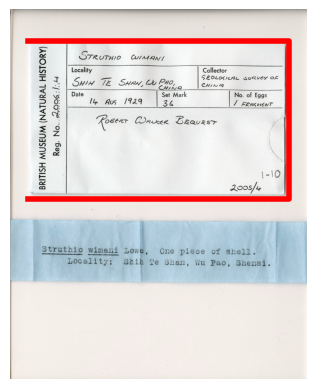

In [16]:
fig,ax = plt.subplots()
ax.imshow(img)
ax.plot(new_box[:,0],new_box[:,1],'-r',linewidth=4)
ax.axis('off')

### Comparing Different Top N Contours

In [26]:
path = '/home/arias1/Documents/GitHub/egg_cards/Images/Drawer_1/cluster1'
files = [f for f in os.listdir(path) if f[-5:] != 'b.jpg']

In [31]:
new_path = '/home/arias1/Documents/GitHub/egg_cards/Images/Drawer_1/tests/top'

In [32]:
errors = []
for f in tqdm.tqdm(files):
    image_path = path+'/'+f
    img = cv2.imread(image_path)
    for t in [2,3,5]:
        try:
            new_image,new_box,contour = find_main_box(img,top=t)
            fig,ax = plt.subplots()
            ax.imshow(img)
            ax.plot(new_box[:,0],new_box[:,1],'-r',linewidth=4)
            ax.axis('off')
            plt.savefig(new_path+str(t)+'/'+f,dpi=600,bbox_inches='tight',pad_inches=0.15)
            plt.close('all')
        except:
            errors.append([f,t])

100%|█████████████████████████████████████████| 159/159 [08:51<00:00,  3.35s/it]


In [33]:
errors

[['001-0044.jpg', 2],
 ['001-0079.jpg', 2],
 ['001-0643a.jpg', 2],
 ['001-0011.jpg', 2]]

#### Accuracies:
Top 2: 110/115 (71% accuracy)

Top 3: 115/159 (72% accuracy)

Top 5: 108/159 (68% accuracy)

### Leeway Test
(Here, we add an extra layer on the left side since there are sometimes mistakes on that side i.e. the main contour box excludes that vertical box within the egg card. Note that we only add a smaller layer on the right side and vertically.)

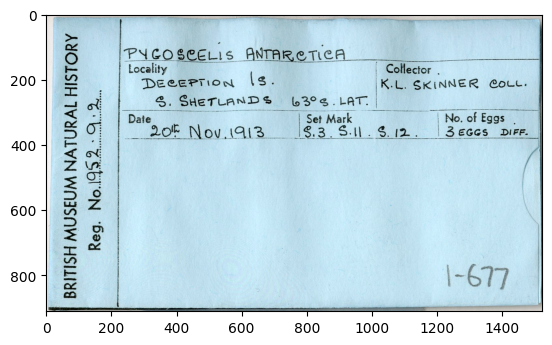

In [59]:
f = '001-0677a.jpg'
image_path = path+'/'+f
img = cv2.imread(image_path)
new_image,new_box,contour = find_main_box(img,top=t,crop_leeway_x=220)
fig,ax = plt.subplots()
ax.imshow(new_image)


#### Drawer 1

In [54]:
good_sample = os.listdir('/home/arias1/Documents/GitHub/egg_cards/Images/Drawer_1/tests/top3/bla')

In [67]:
import matplotlib.image as mpimg
new_path_good = '/home/arias1/Documents/GitHub/egg_cards/Images/Drawer_1/additional_sample'
errors = []
for f in tqdm.tqdm(good_sample):
    try:
        image_path = path+'/'+f
        img = cv2.imread(image_path)
        new_image,new_box,contour = find_main_box(img,top=3,crop_leeway_x=220)
        mpimg.imsave(new_path_good+'/'+f[:-4]+'_cropped.jpg', new_image)
    except:
        errors.append(f)

100%|█████████████████████████████████████████| 115/115 [00:47<00:00,  2.42it/s]


In [68]:
errors

[]

#### Drawer 2

Accuracy: 89/119 = 75%

In [69]:
path = '/home/arias1/Documents/GitHub/egg_cards/Images/Drawer_2/cluster1'
files = [f for f in os.listdir(path) if f[-5:] != 'b.jpg']

In [78]:
import matplotlib.image as mpimg
new_path_good = '/home/arias1/Documents/GitHub/egg_cards/Images/Drawer_2/additional_sample'
errors = []
for f in tqdm.tqdm(files):
    try:
        image_path = path+'/'+f
        img = cv2.imread(image_path)
        new_image,new_box,contour = find_main_box(img,top=3,crop_leeway_x=60,backup_leeway=20)
        mpimg.imsave(new_path_good+'/'+f[:-4]+'_cropped.jpg', new_image)
    except:
        errors.append(f)

100%|█████████████████████████████████████████| 118/118 [00:45<00:00,  2.62it/s]


#### Drawer 3
Accuracy: 111/193 = 58%. Note that here we also excluded that labels that were cropped correctly but a type that was not of interest to us.

In [81]:
path = '/home/arias1/Documents/GitHub/egg_cards/Images/Drawer_3/cluster1'
files = [f for f in os.listdir(path) if f[-5:] != 'b.jpg']

In [84]:
import matplotlib.image as mpimg
new_path_good = '/home/arias1/Documents/GitHub/egg_cards/Images/Drawer_3/additional_sample'
errors = []
for f in tqdm.tqdm(files):
    try:
        image_path = path+'/'+f
        img = cv2.imread(image_path)
        new_image,new_box,contour = find_main_box(img,top=3,crop_leeway_x=220)
        mpimg.imsave(new_path_good+'/'+f[:-4]+'_cropped.jpg', new_image)
    except:
        errors.append(f)

100%|█████████████████████████████████████████| 193/193 [01:06<00:00,  2.90it/s]


In [85]:
len(errors)

0

#### Drawer 58
Accuracy: 220/233 = 94%

In [88]:
path = '/home/arias1/Documents/GitHub/egg_cards/Images/Drawer_58/cluster2'
files = [f for f in os.listdir(path) if f[-5:] != 'b.jpg']

In [105]:
import matplotlib.image as mpimg
new_path_good = '/home/arias1/Documents/GitHub/egg_cards/Images/Drawer_58/additional_sample'
errors = []
for f in tqdm.tqdm(files):
    try:
        image_path = path+'/'+f
        img = cv2.imread(image_path)
        new_image,new_box,contour = find_main_box(img,top=3,crop_leeway_x=220,backup_leeway=60,crop_leeway_y=20)
        mpimg.imsave(new_path_good+'/'+f[:-4]+'_cropped.jpg', new_image)
    except:
        errors.append(f)

100%|█████████████████████████████████████████| 233/233 [01:10<00:00,  3.29it/s]


In [106]:
errors

[]

In [117]:
image_path

'/home/arias1/Documents/GitHub/egg_cards/Images/Drawer_58/cluster2/058-0563.jpg'

In [109]:
image_path = path+'/'+f

In [113]:
img = cv2.imread(image_path)
import skimage.io as io
img2 = io.imread(image_path)

In [112]:
image_path

'/home/arias1/Documents/GitHub/egg_cards/Images/Drawer_58/cluster2/058-0563.jpg'

In [115]:
new_image,new_box,contour = find_main_box(img2,top=3,crop_leeway_x=220,backup_leeway=60,crop_leeway_y=20)
mpimg.imsave('_cropped.jpg', new_image)

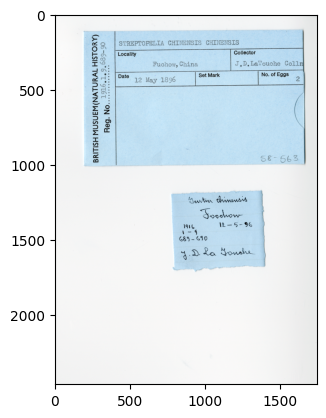

In [111]:
fig,ax = plt.subplots()
ax.imshow(img)

In [118]:
mpimg.imsave('t1.jpg', img)
mpimg.imsave('t2.jpg', img2)


In [120]:
image_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
c1 = measure.find_contours(image_grey/255, 0.8)

In [121]:
image_grey = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
c2 = measure.find_contours(image_grey/255, 0.8)

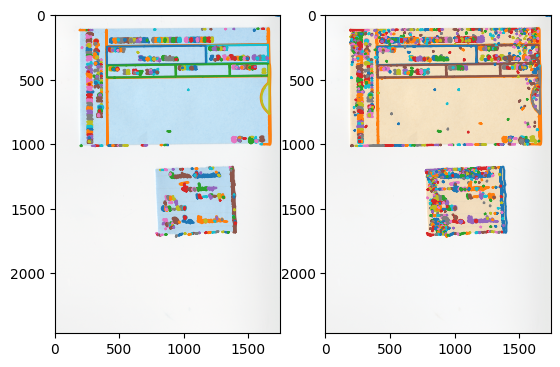

In [128]:
fig,ax = plt.subplots(1,2)
ax[0].imshow(img)
ax[1].imshow(img2)

for c in c1:
    if len(c[:,0]) > 20:
        ax[0].plot(c[:,1],c[:,0])
    
for c in c2:
    if len(c[:,0]) > 20:
        ax[1].plot(c[:,1],c[:,0])

In [126]:
contours_length

NameError: name 'contours_length' is not defined

In [127]:
contours_length

NameError: name 'contours_length' is not defined